# <center> Recommender Systems
## <center> Collaborative Filtering; Content Based; Hybrid System
    
Here in this notebook, we would like to create a recommender system based on dataset found [here](https://grouplens.org/datasets/movielens/). It is categorized as a small dataset with the detail of 100,000 ratings and 3,600 tag applications which are applied to 9,000 movies by 600 users.

In this notebook, we also implemented a couple of methods in recommender systems such as Apriori Algorithm, Collaborative Filtering, Content-Based Filtering, and Hybrid Modeling.
    
    Author: Tri Juliansyah Muharam Sambas; Rangga Pratama
    Date: 15th November 2019

## Outline
- TLDR; Executive Summary
- Importing Libraries
- Importing Dataset
    * Data Preprocessing
        - Data Cleaning
        - Data Encoding
- Exploratory Data Analysis
- Modeling & Simulation
    * Apriori Modeling
    * Collaborative Filtering
        - Dataset Splitting
        - User-Based
        - Item-Based
        - Singular Value Decomposition
    * Content-Based Filtering
    * Hybrid Modeling

## TLDR; Executive Summary

Here are the highlighted points on the analysis:
- In this notebook, we created a movie recommender system for each user based on their previous historical rated movies or their neighbor users (choosing either one of them and depend on the method).
- We discuss 4 methods of recommender system,
    * Apriori Model (useful for finding similar type of movies that have been seen before)
    * Collaborative Filtering (useful for predicting users rating on each movie)
    * Content-Based Filtering (useful for suggesting movies based on historical seen movies)
    * Hybrid Modeling (combination of collaborative and content-based filtering, to optimize the recommendations)
- On Collaborative Filtering methods, we discuss three basic methods, User-based, Item-based, and Singular value Decomposition. The **SVD method came out as the best method with RMSE 2.992** beating the other two with **more than 3 points of RMSE**.
- The minimum RMSE on SVD method is reached when we implement the parameter **k = 10**.
- On the Content-Based method, we **collected external data** from previous practice in which **additional information** regarding each movie are available such as **director, rating, facebook likes, actor likes and etc.** Using these information, we could produce the clusters of each movie and generate the prediction for a specific user.
- Further, we also consider the suggested movies to be as close as possible to the chosen cluster. Therefore, the suggestions are more reliable based on the user historical seen movies.
- Lastly, we implement Hybrid method by combining the result of Collaborative Filtering (SVD) and Content-based Filtering in which we **suggested the intersection of first 100 suggested results between the two**. For example, userId = 1, she/he has the suggestions to watch:
    * Tin Cup
    * Drag Me to Hell
    * Prom Night
    * Kate & Leopold
    * Meet the Parents
    * Dawn of the Dead
    * Fantastic Four
    * so on...
- **All in all**, here in this notebook, the results are still far from optimal, since we have not optimize the parameter and try other fancy methods to minize the RMSE. Nevertheless, the purpose of this notebook is to get the main idea of how the recommender systems work.

## Import Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Words visualization
from wordcloud import WordCloud

# Machine learning
from sklearn.cluster import KMeans
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

# Others
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [2]:
# importing rating from github
rating_source = 'https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/ratings.csv'
df = pd.read_csv(rating_source)

# deleting unneeded column
del df['timestamp']

# importing title from github
title_source = 'https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/movies.csv'
title = pd.read_csv(title_source)

# merging dataset with title
df = pd.merge(df, title, on = 'movieId', how = 'left')

# importing tags from github
tags = pd.read_csv('https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/tags.csv')

# deleting uneeded column
del tags['timestamp']

# merging dataset with tags
df = pd.merge(df, tags, on = ['movieId','userId'], how = 'left')

In [3]:
df.head(3)

,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,NaN
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,NaN


In [4]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

print('The number of users: ' + str(n_users))
print('The number of movie: ' + str(n_movies))

The number of users: 610
The number of movie: 9724


### Data Preprocessing

#### Data Cleaning

In [5]:
year = []
title = []
title_df = list(df['title'])
for i in range(len(title_df)) :
    if title_df[i][-2].isdigit() == True :
        year.append(title_df[i][-5:-1])
        title.append(title_df[i][:-6])
    else :
        year.append('NaN')
        title.append(title_df[i])
        
df['title'] = title
df['year'] = year

#### New Encoding (Only Applied to Collaborative Filtering)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
encoder = LabelEncoder()

In [8]:
df['movieId_new'] = encoder.fit_transform(df['movieId'])
df['userId_new'] = encoder.fit_transform(df['userId'])

In [9]:
# creating a movie list
movie_list = df[['movieId_new','title']].drop_duplicates().sort_values(by = 'movieId_new').set_index('movieId_new')

## Exploratory Data Analysis

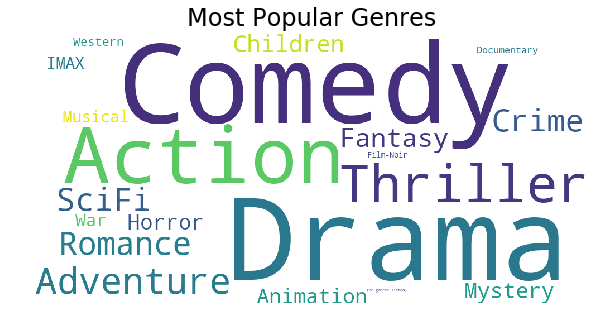

In [10]:
# creating wordcloud of the most popular genres
plt.figure(figsize = (10,10))
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 500, max_words = 100).generate_from_frequencies(Counter(','.join(df['genres'].str.replace('|',',')).replace('Sci-Fi','SciFi').split(',')))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Genres',fontsize = 24)
plt.show()

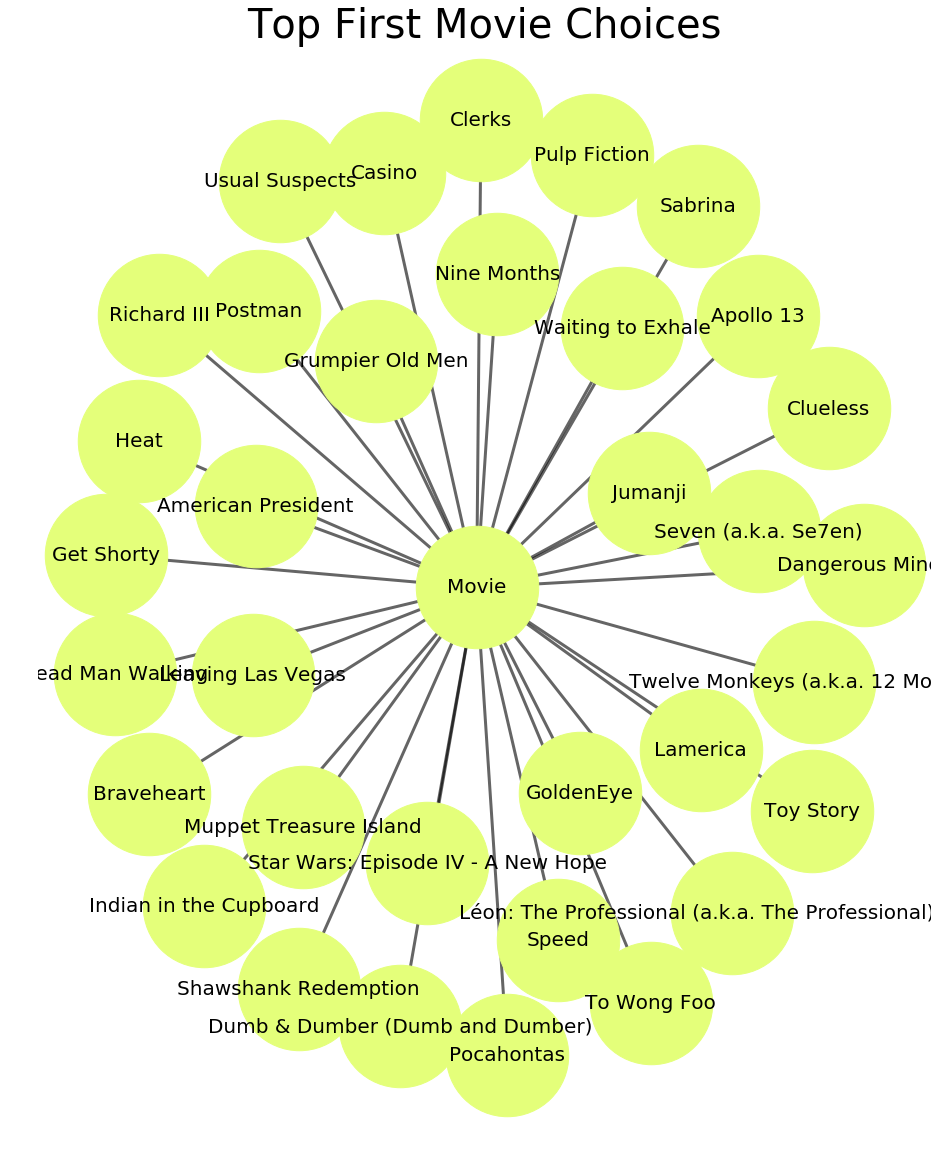

In [11]:
# listing top first movie to watch
df_nx = pd.DataFrame(df['userId'].unique()).rename(columns = {0 : 'userId'})
df['title'] = df['title'].str.rstrip()
listuser = list(df_nx['userId'])
listtitle = []
for i in range(len(listuser)) :
    title = ', '.join(df[df['userId'] == listuser[i]]['title'])
    listtitle.append(title)
df_nx['title'] = listtitle
del df_nx['userId']

df_nx = df_nx['title'].str.split(',', expand = True)

df_nx['movie'] = 'Movie'
movie = df_nx.truncate(before = -1, after = 100)

movie = nx.from_pandas_edgelist(movie, source = 'movie', target = 0, edge_attr = True)

plt.rcParams['figure.figsize'] = (16, 20)
pos = nx.spring_layout(movie)
color = plt.cm.Wistia(np.linspace(0, 5, 1))
nx.draw_networkx_nodes(movie, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(movie, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(movie, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top First Movie Choices', fontsize = 40)
plt.show()

Text(0.5, 1.0, 'Minimum Support 0.3')

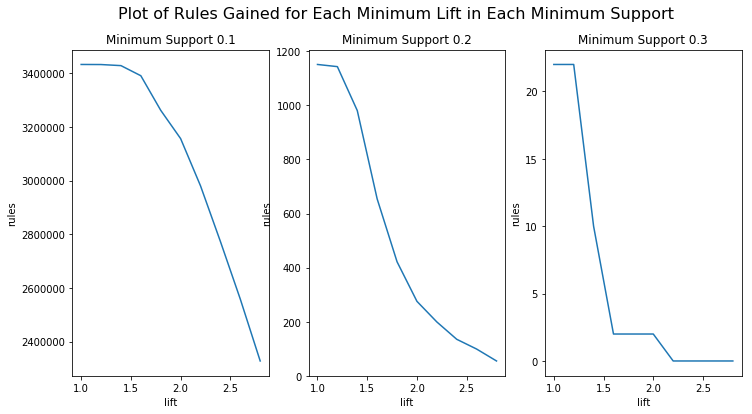

In [12]:
# plotting rules gained for each minimum lift and each minimum support to find the most optimal point
movielist = []
for i in df['userId'].unique() :
    mlist = list(set(df[df['userId'] == i]['title']))
    if len(mlist) > 0 :
        movielist.append(mlist)

te = TransactionEncoder()
te_ary = te.fit(movielist).transform(movielist)
df_apriori = pd.DataFrame(te_ary, columns = te.columns_)

list_supp = [0.1,0.2,0.3]
list_lift = [1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8]
rules_each_lift = []
for i in tqdm(list_supp): 
    frequent_moviesets = apriori(df_apriori, min_support = i)
    for j in tqdm(list_lift):
        rules = association_rules(frequent_moviesets, metric = 'lift', min_threshold = j)
        rules_each_lift.append(len(rules))

rules_each_lift = [rules_each_lift[i:i + 10] for i in range(0, len(rules_each_lift), 10)]
rules_a = rules_each_lift[0]
rules_b = rules_each_lift[1]
rules_c = rules_each_lift[2]

plt.figure(figsize = (12,6))
plt.suptitle('Plot of Rules Gained for Each Minimum Lift in Each Minimum Support', size = 16)

plt.subplot(1,3,1)
a = sns.lineplot(x=list_lift, y = rules_a)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.1')

plt.subplot(1,3,2)
b = sns.lineplot(x=list_lift, y = rules_b)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.2')

plt.subplot(1,3,3)
c = sns.lineplot(x=list_lift, y = rules_c)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.3')

plt.show()

## Modeling

### Apriori

In [18]:
# from the EDA above, we choose min_support = 0.1 and min_threshold 1.6 as the optimal point
frequent_moviesets = apriori(df_apriori, min_support = 0.1, use_colnames = True)
rules = association_rules(frequent_moviesets, metric = 'lift', min_threshold = 1.6)
rules.sort_values('confidence', ascending = False) 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2509288,(Star Wars: Episode V - The Empire Strikes Bac...,(Star Wars: Episode IV - A New Hope),0.113115,0.411475,0.113115,1.00000,2.430279,0.066571,inf
3224844,"(Back to the Future, Star Wars: Episode V - Th...","(Star Wars: Episode IV - A New Hope, Star Wars...",0.100000,0.286885,0.100000,1.00000,3.485714,0.071311,inf
2555942,"(Kill Bill: Vol. 1, Matrix, The, Silence of th...","(Lord of the Rings: The Return of the King, The)",0.100000,0.303279,0.100000,1.00000,3.297297,0.069672,inf
776345,"(Lord of the Rings: The Two Towers, The, Fight...","(Matrix, The)",0.104918,0.455738,0.104918,1.00000,2.194245,0.057103,inf
1653386,"(Pulp Fiction, True Lies, Jurassic Park, Ace V...",(Forrest Gump),0.100000,0.539344,0.100000,1.00000,1.854103,0.046066,inf
2555938,"(Kill Bill: Vol. 1, Lord of the Rings: The Ret...","(Lord of the Rings: The Two Towers, The)",0.100000,0.308197,0.100000,1.00000,3.244681,0.069180,inf
1797077,"(Back to the Future, Star Wars: Episode V - Th...",(Star Wars: Episode VI - Return of the Jedi),0.101639,0.321311,0.101639,1.00000,3.112245,0.068981,inf
1435267,"(Terminator, The, Star Wars: Episode VI - Retu...",(Star Wars: Episode V - The Empire Strikes Back),0.101639,0.345902,0.101639,1.00000,2.890995,0.066482,inf
702968,"(Gladiator, Star Wars: Episode IV - A New Hope...","(Matrix, The)",0.100000,0.455738,0.100000,1.00000,2.194245,0.054426,inf
3122048,"(Terminator, The, Sixth Sense, The, Jurassic P...",(Star Wars: Episode V - The Empire Strikes Back),0.106557,0.345902,0.106557,1.00000,2.890995,0.069699,inf


#### Simulation of Recommendation by Apriori Algorithm

In [46]:
# creating "basket" of movies given a movie title (so we can recommend another movies to watch after a certain movie)
watched = 'Toy Story '   # INPUT THE TITLE AND GIVE SPACE IN THE END

dum = rules[rules['consequents'] == frozenset({watched})].sort_values(by = 'lift', ascending = False).head(5)
dum['len'] = len(dum['antecedents'])

for x in dum.sort_values(by = 'len').head(1)['antecedents'].apply(lambda x : list(x)).astype('unicode'):
    print(x)

['Pulp Fiction', 'Back to the Future', 'Indiana Jones and the Last Crusade', 'Jurassic Park', 'Star Wars: Episode IV - A New Hope']


So after a person watch Toy Story, based on the apriori algorithm, it's better to recommend him Jurassic Park, Pulp Fiction, Indiana Jones and the Last Crusade, Back to the Future, Star Wars : Episode IV - A New Hope

### Collaborative Filtering

#### Dataset Splitting
Splitting dataset into two parts: training and test to validate the fitness of the model.

##### Splitting

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_data, test_data = train_test_split(df, test_size=0.25, random_state = 42)

In [15]:
print('Your train shape is: %i x %i' %train_data.shape)
print('Your test shape is: %i x %i' %test_data.shape)

Your train shape is: 77007 x 9
Your test shape is: 25670 x 9


##### Rating Matrices
Rating matrices contain the rating of each user (as rows) on each movie (as columns).

In [16]:
# Create two user-item matrices, one for training and another for testing
# Matrix[new_user,new_movie] = rating
train_data_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_data_matrix[line[-1]-1, line[-2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[-1]-1, line[-2]-1] = line[3]

In [90]:
list(train_data.itertuples())[0]

Pandas(Index=81600, userId=509, movieId=3301, rating=3.5, title='Whole Nine Yards, The', genres='Comedy|Crime', tag=nan, year='2000', movieId_new=2476, userId_new=508)

In [17]:
print('Your train data matrix is: %i x %i' %train_data_matrix.shape)
print('Your test data matrix is: %i x %i' %test_data_matrix.shape)

Your train data matrix is: 610 x 9724
Your test data matrix is: 610 x 9724


#### Non-Probabilistic

##### Similarity Function
The similarity function used in this notebook is **Cosine Similarity**. Cosine similiarity for users *k* and *a* can be calculated using the formula below, where you take dot product of  **the user** vector *$u_k$* and **the user** vector *$u_a$* and divide it by multiplication of the Euclidean lengths of the vectors.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

To calculate similarity **between items** *m* and *b* you use the formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

Further detail can be found on a course on Udemy, [here](https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/).

In [20]:
from sklearn.metrics.pairwise import pairwise_distances

In [21]:
train_similarity = pairwise_distances(train_data_matrix, metric='cosine')
print('Your train similarity matrix shape is: %i x %i' %train_similarity.shape)

Your train similarity matrix shape is: 610 x 610


In [22]:
test_similarity = pairwise_distances(test_data_matrix, metric='cosine')
print('Your test similarity matrix shape is: %i x %i' %test_similarity.shape)

Your test similarity matrix shape is: 610 x 610


##### User-Based
To make a prediction, the next step is imputing the similarity matrices above to the equation below,

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

where *k* and *m* represent the user *k-th* on item *m*. So that, we could compute the rating that users would make if they have already introduced each movie.

In [23]:
def user_based_prediction(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1)
    #You use np.newaxis so that mean_user_rating has same format as ratings
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

In [24]:
prediction = user_based_prediction(train_data_matrix, train_similarity)

##### Model Evaluation

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [26]:
print('User-based CF RMSE: ' + str(rmse(prediction, test_data_matrix)))

User-based CF RMSE: 3.308396171594543


##### Item-Based
The concept of item-based similar to the user-based except, we do not need to compare the ratings of the other users. Instead, we calculate the similarity between movies.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>


##### Similarity Function

In [27]:
train_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
print('Your train similarity matrix shape is: %i x %i' %train_similarity.shape)

Your train similarity matrix shape is: 9724 x 9724


In [28]:
test_similarity = pairwise_distances(test_data_matrix.T, metric='cosine')
print('Your test similarity matrix shape is: %i x %i' %test_similarity.shape)

Your test similarity matrix shape is: 9724 x 9724


In [29]:
def item_based_prediction(ratings, similarity):
    pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)]) 
    return pred

In [30]:
prediction = item_based_prediction(train_data_matrix, train_similarity)

##### Model Evaluation

In [32]:
print('Item-based CF RMSE: ' + str(rmse(prediction, test_data_matrix)))

Item-based CF RMSE: 3.5272727600253333


#### Singular Value Decomposition

In [ ]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

##### Optimization of k-latent feature in SVD

Best k value for Minimum RMSE: 10


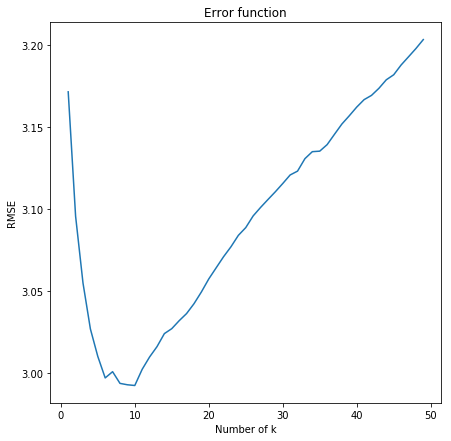

In [98]:
rmse_val = []
min_rmse = 1000
min_k = 0
for k in tqdm(range(1,50)): # grid search for k
    u, s, vt = svds(train_data_matrix, k = k)
    s_diag_matrix = np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    rmse_val.append(rmse(X_pred, test_data_matrix))
    if rmse(X_pred, test_data_matrix) < min_rmse:
        min_k = k
        min_rmse = rmse(X_pred, test_data_matrix)
    
# checking the best number of clusters based on content of unwatched movie
print('Best k value for Minimum RMSE: %i' %min_k)
plt.figure(figsize = (7,7))
plt.plot(range(1, 50), rmse_val)
plt.title('Error function')
plt.xlabel('Number of k')
plt.ylabel('RMSE')
plt.show()

##### Optimal Result

In [99]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 10)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

print('User-based CF MSE (using SVD): ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE (using SVD): 2.9924246752476638


#### Simulation on Collaborative Filtering

In [100]:
from ipywidgets import interact

@interact
def cf_suggestion(user=df['userId'].unique(), pred_method = ['user','item','svd'], num_to_suggest = 10 , return_values = False):
    # Create two user-item matrices, one for training and another for testing
    # Matrix[new_user_id,new_movie_id] = rating
    n_users = df['userId'].nunique()
    n_movies = df['movieId'].nunique()
    data_matrix = np.zeros((n_users, n_movies))
    for line in df.itertuples():
        data_matrix[line[-1]-1, line[-2]-1] = line[3]
    
    # ratings calculation
    if pred_method == 'user': # user-based
        similarity_matrix = pairwise_distances(data_matrix, metric='cosine')
        prediction_matrix = user_based_prediction(data_matrix, similarity_matrix)
    elif pred_method == 'item': # item-based
        similarity_matrix = pairwise_distances(data_matrix.T, metric='cosine')
        prediction_matrix = item_based_prediction(data_matrix, similarity_matrix)
    elif pred_method == 'svd': # svd
        u, s, vt = svds(data_matrix, k = 10)
        s_diag_matrix = np.diag(s)
        prediction_matrix = np.dot(np.dot(u, s_diag_matrix), vt)
    
    # rating for all movies by the user
    ranks_from_user = prediction_matrix[user - 1,:]
    
    # creating movie list
    pred_movie_list = movie_list.copy()
    pred_movie_list['real_review'] = data_matrix[user - 1,:]
    pred_movie_list['pred_review'] = ranks_from_user
    
    # sorting predicted movie list
    pred_movie_list.sort_values(by = 'pred_review', ascending = False, inplace=True)
    pred_movie_list.reset_index(inplace = True)
    
    # listed 10 not yet reviewed movies
    to_suggest = pred_movie_list.loc[pred_movie_list['real_review'] == 0,'title'][:num_to_suggest].values
    print('Your movie top %i suggestions are: \n' %num_to_suggest)
    for movie in to_suggest:
        print(movie)
    
    if return_values:
        return to_suggest

interactive(children=(Dropdown(description='user', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### Content-Based

#### Data Preparation

In [35]:
# preparing data for content based
additional_source = 'https://raw.githubusercontent.com/ranggarppb/movie_recommendation_netflix/master/movie_metadata.csv'
movie_data = pd.read_csv(additional_source)

movie_data.drop(['director_name','actor_2_name','genres','actor_1_name','actor_3_name','movie_imdb_link','title_year','plot_keywords'], axis = 1, inplace = True)
movie_data.dropna(axis = 0, inplace = True)
movie_data['movie_title'] = movie_data['movie_title'].str.strip()

In [36]:
df_content_based = df.copy()
df_content_based = df_content_based.rename(columns = {'title' : 'movie_title'})
df_content_based['genres'] = df_content_based['genres'].str.replace('|',' ')
df_content_based['genres'] = df_content_based['genres'].str.split(' ').str.get(0)
del df_content_based['tag']
df_content_based = pd.merge(df_content_based,movie_data, on = 'movie_title', how = 'left').dropna(axis = 0)
df_content_based.drop_duplicates(subset = ['userId','movieId','rating'], inplace = True)
df_content_based['year'] = df_content_based['year'].astype(str)
df_content_based = pd.get_dummies(df_content_based, columns = ['genres','color','language','country','content_rating'])

In [37]:
df_content_based.head(3)

,userId,movieId,rating,movie_title,year,movieId_new,userId_new,num_critic_for_reviews,duration,director_facebook_likes,...,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
0,1,1,4.0,Toy Story,1995,0,0,166.0,74.0,487.0,...,0,0,0,0,0,0,0,0,0,0
5,1,70,3.0,From Dusk Till Dawn,1996,62,0,165.0,108.0,0.0,...,0,0,0,0,0,0,0,1,0,0
6,1,101,5.0,Bottle Rocket,1996,89,0,83.0,91.0,0.0,...,0,0,0,0,0,0,0,1,0,0


#### K-Means Clustering

In [38]:
# input userId
userId = 1

In [39]:
# list of movie_title watched by userId
col = [col for col in df_content_based.columns if col not in ['userId','movieId','movie_title','year']]
user_movie = df_content_based[df_content_based['movie_title'].isin(list(df_content_based[df_content_based['userId'] == 1]['movie_title'].unique()))][col]

In [40]:
# list of mean of all content (numerical characteristic of the movie watched by the user)
user_movie_mean = pd.DataFrame(user_movie.mean().to_dict(), index = [user_movie.index.values[-1]])

In [41]:
# getting another movie not yet watched by the userId
col2 = [col for col in df_content_based.columns if col not in ['userId','movieId','year']]
user_not_watched = user_movie = df_content_based[~df_content_based['movie_title'].isin(list(df_content_based[df_content_based['userId'] == 1]['movie_title'].unique()))][col2]

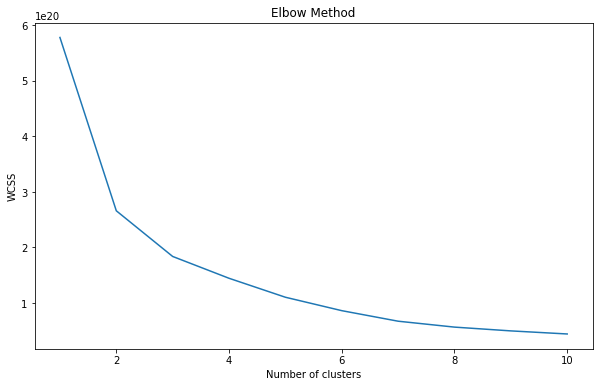

In [42]:
# checking the best number of clusters based on content of unwatched movie
plt.figure(figsize = (10,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(user_not_watched.drop('movie_title', axis = 1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [43]:
# choose 6 clusters
kmeans = KMeans(n_clusters=6, max_iter=600, algorithm = 'auto')
kmeans.fit(user_not_watched.drop('movie_title', axis = 1))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(6)
user_not_watched['cluster'] = pd.DataFrame(lut[kmeans.labels_])
user_not_watched.dropna(axis = 0,inplace = True)
user_not_watched['cluster'] = user_not_watched['cluster'].astype(int)

#### Simulation on Content-Based Filtering

In [44]:
# fitting the clustering to the movie watched by userId and get all movie in the unwatched movie which match with the cluster
to_recommend = user_not_watched[user_not_watched['cluster'] == kmeans.predict(user_movie_mean)[0]]

In [45]:
# choosing only 5 movies with closest Euclidian Distance to user_movie_mean
def Euclidean_Dist(to_recommend, user_movie_mean, cols=[col for col in to_recommend.columns if col not in ['cluster','movie_title']]):
    return np.linalg.norm(to_recommend[cols].values - user_movie_mean[cols].values,
                   axis=1)
to_recommend['dist'] = Euclidean_Dist(to_recommend, pd.concat([user_movie_mean]*len(to_recommend), ignore_index = True))

for x in list(to_recommend.sort_values(by = 'dist')['movie_title'].unique()[0:5]) :
    print(x)

American Hustle
Lethal Weapon 3
We're the Millers
Rambo: First Blood Part II
Gran Torino


#### Visualization
PCA is meant to reduce the dimension of the dataset for content-based filtering. **However,** the minimum number of component to explain most of variance (at least 80%) is more than 2. Therefore, **it is not possible** to plot only the component 1 and 2 since it will only explain less than 50% of dataset variance.

In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [66]:
pca = PCA()

In [67]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(user_not_watched.drop('movie_title', axis = 1))

In [68]:
pca.fit(data_rescaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

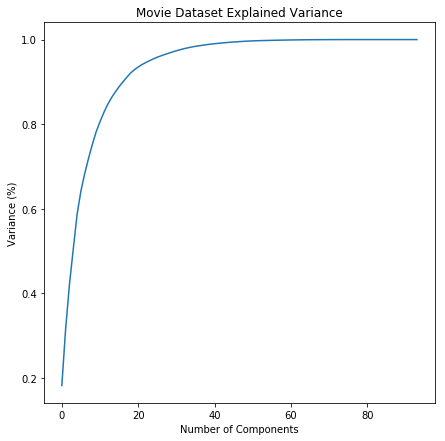

In [70]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize = (7,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Movie Dataset Explained Variance')
plt.show()

### Hybrid

In [104]:
# listing all the movie from content based method and preparing the data for creating the matrix for collaboration filtering
to_recommend = user_not_watched[user_not_watched['cluster'] == kmeans.predict(user_movie_mean)[0]]
to_recommend['dist'] = Euclidean_Dist(to_recommend, pd.concat([user_movie_mean]*len(to_recommend), ignore_index = True))
list_movie_content = list(to_recommend.sort_values(by = 'dist')['movie_title'].unique())

In [106]:
to_suggest = cf_suggestion(userId, pred_method = 'svd', num_to_suggest = 100, return_values = True)
to_suggest = list(to_suggest)
to_suggest = [x.strip() for x in to_suggest]

Your movie top 100 suggestions are: 

Someone to Watch Over Me 
Pyromaniac's Love Story, A 
Flintstones, The 
Tin Cup 
Batman 
When Night Is Falling 
Savage Nights (Nuits fauves, Les) 
Walk on the Moon, A 
Drag Me to Hell 
Girl with a Pearl Earring 
Third Man, The 
In the Electric Mist 
Princess (Prinsessa) 
Yellow Submarine 
Paris Is Burning 
Vampires 
How to Make an American Quilt 
Radio Day 
Prom Night 
Children of Huang Shi, The 
Alice 
Morvern Callar 
About Last Night 
DeadHeads 
Quicksilver 
Kate & Leopold 
Meet the Parents 
Dawn of the Dead 
Charlie Bartlett 
Quo Vadis 
Northanger Abbey 
Purge: Anarchy, The 
Candyman: Farewell to the Flesh 
Fantastic Four 
Whiplash 
Perfect Getaway, A 
Dish, The 
Doubt 
Jane Austen's Mafia! 
Massu Engira Maasilamani 
Children of Men 
Nativity Story, The 
Blues Brothers, The 
Tell No One (Ne le dis à personne) 
Diving Bell and the Butterfly, The (Scaphandre et le papillon, Le) 
Road, The 
King of California 
It's Complicated 
Sidewalls (Medianera

#### Simulation on Hybrid Method

In [107]:
print('Your movie suggestions based on Hybrid Method are: ')
for x in to_suggest :
    if x in list_movie_content :
        print(x)

Your movie suggestions based on Hybrid Method are: 
Tin Cup
Drag Me to Hell
Prom Night
Kate & Leopold
Meet the Parents
Dawn of the Dead
Fantastic Four
Whiplash
Doubt
Children of Men
It's Complicated
A Million Ways to Die in the West
Deuce Bigalow: Male Gigolo
Contagion
Good Luck Chuck
Hellboy II: The Golden Army
Kiss of Death
Megamind
The Interview
Captain America: The First Avenger
Wreck-It Ralph
Lawrence of Arabia
